# 1. Import Ntuple

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
from termcolor import colored
import pandas as pd
import numpy as np
import uproot
from tqdm.auto import tqdm
tqdm.pandas()
import sys
sys.path.append('/home/belle/zhangboy/inclusive_R_D/')
import utilities as util
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.tab20.colors)

training_variables = util.training_variables
columns = util.all_relevant_variables #+ ['ell_GMdaughter_0_PDG','ell_GMdaughter_1_PDG',
                                       #  'ell_Mdaughter_0_PDG','ell_Mdaughter_1_PDG']

In [2]:
local_mc = uproot.concatenate([f'../../Samples/Generic_MC15ri/e_channel/MC15ri_local_200fb/*.root:B0'],
                          library="np")
df_test = pd.DataFrame(local_mc)

In [12]:
# for p in ['D','ell']:
#     df_test.eval(f'{p}_px_pull = ({p}_CMS_px - {p}_CMS_mcPX)/{p}_CMS_pxErr', inplace=True)
#     df_test.eval(f'{p}_py_pull = ({p}_CMS_py - {p}_CMS_mcPY)/{p}_CMS_pyErr', inplace=True)
#     df_test.eval(f'{p}_pz_pull = ({p}_CMS_pz - {p}_CMS_mcPZ)/{p}_CMS_pzErr', inplace=True)

In [5]:
df_test.columns.tolist()

['__experiment__',
 '__run__',
 '__event__',
 '__production__',
 '__candidate__',
 '__ncandidates__',
 '__weight__',
 'Ecms',
 'ROEeidBDT',
 'ROEmuidBDT',
 'B0_Mbc',
 'B0_deltaE',
 'B0_roeMbc_my_mask',
 'B0_roeM_my_mask',
 'B0_roeDeltae_my_mask',
 'B0_roeCharge_my_mask',
 'B0_roeNeextra_my_mask',
 'B0_roeEextra_my_mask',
 'B0_nROE_Charged_my_mask',
 'B0_nROE_ECLClusters_my_mask',
 'B0_nROE_NeutralECLClusters_my_mask',
 'B0_nROE_KLMClusters',
 'B0_nROE_NeutralHadrons_my_mask',
 'B0_nROE_Photons_my_mask',
 'B0_nROE_Tracks_my_mask',
 'B0_nROE_Composites_my_mask',
 'B0_nROE_e',
 'B0_nROE_mu',
 'B0_nROE_K',
 'B0_nROE_pi',
 'B0_isContinuumEvent',
 'B0_R2',
 'B0_thrustBm',
 'B0_thrustOm',
 'B0_cosTBTO',
 'B0_cosTBz',
 'B0_KSFWV1',
 'B0_KSFWV2',
 'B0_KSFWV3',
 'B0_KSFWV4',
 'B0_KSFWV5',
 'B0_KSFWV6',
 'B0_KSFWV7',
 'B0_KSFWV8',
 'B0_KSFWV9',
 'B0_KSFWV10',
 'B0_KSFWV11',
 'B0_KSFWV12',
 'B0_KSFWV13',
 'B0_KSFWV14',
 'B0_KSFWV15',
 'B0_KSFWV16',
 'B0_KSFWV17',
 'B0_KSFWV18',
 'B0_CC1',
 'B0_CC2

In [3]:
# load MVA
import lightgbm as lgb
# load model to predict
bst_lgb = lgb.Booster(model_file=f'../../BDTs/LightGBM/lgbm_multiclass.txt')
cut='signal_prob==largest_prob and signal_prob>0.8 and \
continuum_prob<0.04 and fakeD_prob<0.05'
# cut = 'signal_prob<0.3 and continuum_prob>0.8 and fakeD_prob<0.05'

In [4]:
df_test.eval('B_D_ReChi2 = B0_vtxReChi2 + D_vtxReChi2', inplace=True)
df_test.eval(f'p_D_l = D_CMS_p + ell_CMS_p', inplace=True)
# df_test['D_daughter_pValue_min'] = df_test[['D_K_pValue','D_pi1_pValue','D_pi2_pValue']].min(axis=1)
# df_test['D_daughter_pValue_mean'] = df_test[['D_K_pValue','D_pi1_pValue','D_pi2_pValue']].mean(axis=1)

In [5]:
pred_test = bst_lgb.predict(df_test[training_variables], num_iteration=50) #bst_lgb.best_iteration
lgb_out_test = pd.DataFrame(pred_test, columns=['signal_prob','continuum_prob','fakeD_prob','fakeB_prob'])

df_lgb_test = pd.concat([df_test, lgb_out_test], axis=1)
df_lgb_test['largest_prob'] = df_lgb_test[['signal_prob','continuum_prob','fakeD_prob','fakeB_prob']].max(axis=1)
del pred_test, lgb_out_test

df_cut_test=df_lgb_test.query(cut)
df_bestSelected_test=df_cut_test.loc[df_cut_test.groupby(['__experiment__','__run__','__event__','__production__']).B_D_ReChi2.idxmin()]

In [11]:
samples=util.get_dataframe_samples_new(df_bestSelected_test, 'e', template=False)
mpl=util.mpl(samples)
for name, df in samples.items():
    print(name, len(df))

bkg_FakeD 365671
bkg_TDFl 3496
bkg_fakeTracks 4946
bkg_continuum 27023
bkg_combinatorial 273
bkg_singleBbkg 89
bkg_other_TDTl 0
$D\tau\nu$ 8
$D^\ast\tau\nu$ 5
$D\ell\nu$ 676
$D^\ast\ell\nu$ 346
$D^{\ast\ast}\tau\nu$ 6
$D^{\ast\ast}\ell\nu$ 188
$D\ell\nu$_gap 73
bkg_other_signal 0


In [7]:
columns_without_nan = df_bestSelected_test.columns[~df_bestSelected_test.isna().any()].tolist()

samples=util.get_dataframe_samples_new(df_bestSelected_test, 'e', template=False)
mpl=util.mpl(samples)
# df_conti_conti = samples['bkg_continuum']
for name, df in samples.items():
    print(name, len(df))

bkg_FakeD 16626
bkg_TDFl 919
bkg_fakeTracks 496
bkg_continuum 1455
bkg_combinatorial 2376
bkg_singleBbkg 1404
bkg_other_TDTl 0
$D\tau\nu$ 1016
$D^\ast\tau\nu$ 530
$D\ell\nu$ 14129
$D^\ast\ell\nu$ 9377
$D^{\ast\ast}\tau\nu$ 305
$D^{\ast\ast}\ell\nu$ 5333
$D\ell\nu$_gap 1105
bkg_other_signal 0


In [23]:

# Define the fitting range and number of bins, 'p_D_l'
start = 0.5 # 0.8 before adding fakeD
end = 5
num_bins = 40

# Create the bin edges
p_D_l_bins = np.linspace(start, end, num_bins + 1)

# Define the fitting range and number of bins, 'B0_CMS3_weMissM2'
start = -5 # -1.1 before adding fakeD
end = 10 # 8.6 before adding fakeD
num_bins = 50

# Create the bin edges
MM2_bins = np.linspace(start, end, num_bins + 1)

bin_threshold = 1

In [15]:
test_histograms = {}
test_staterr = {}
for name, df in {'true_cont':samples['bkg_continuum']}.items():

    (counts, xedges, yedges) = np.histogram2d(df['B0_CMS3_weMissM2'], 
                                              df['p_D_l'],
                                              bins=[MM2_bins, p_D_l_bins],
                                              weights=df['__weight__'])

    (staterr_squared, xedges, yedges) = np.histogram2d(df['B0_CMS3_weMissM2'], 
                                                       df['p_D_l'],
                                                       bins=[MM2_bins, p_D_l_bins],
                                                       weights=df['__weight__']**2)
    test_histograms[name] = counts
    test_staterr[name] = np.sqrt(staterr_squared)

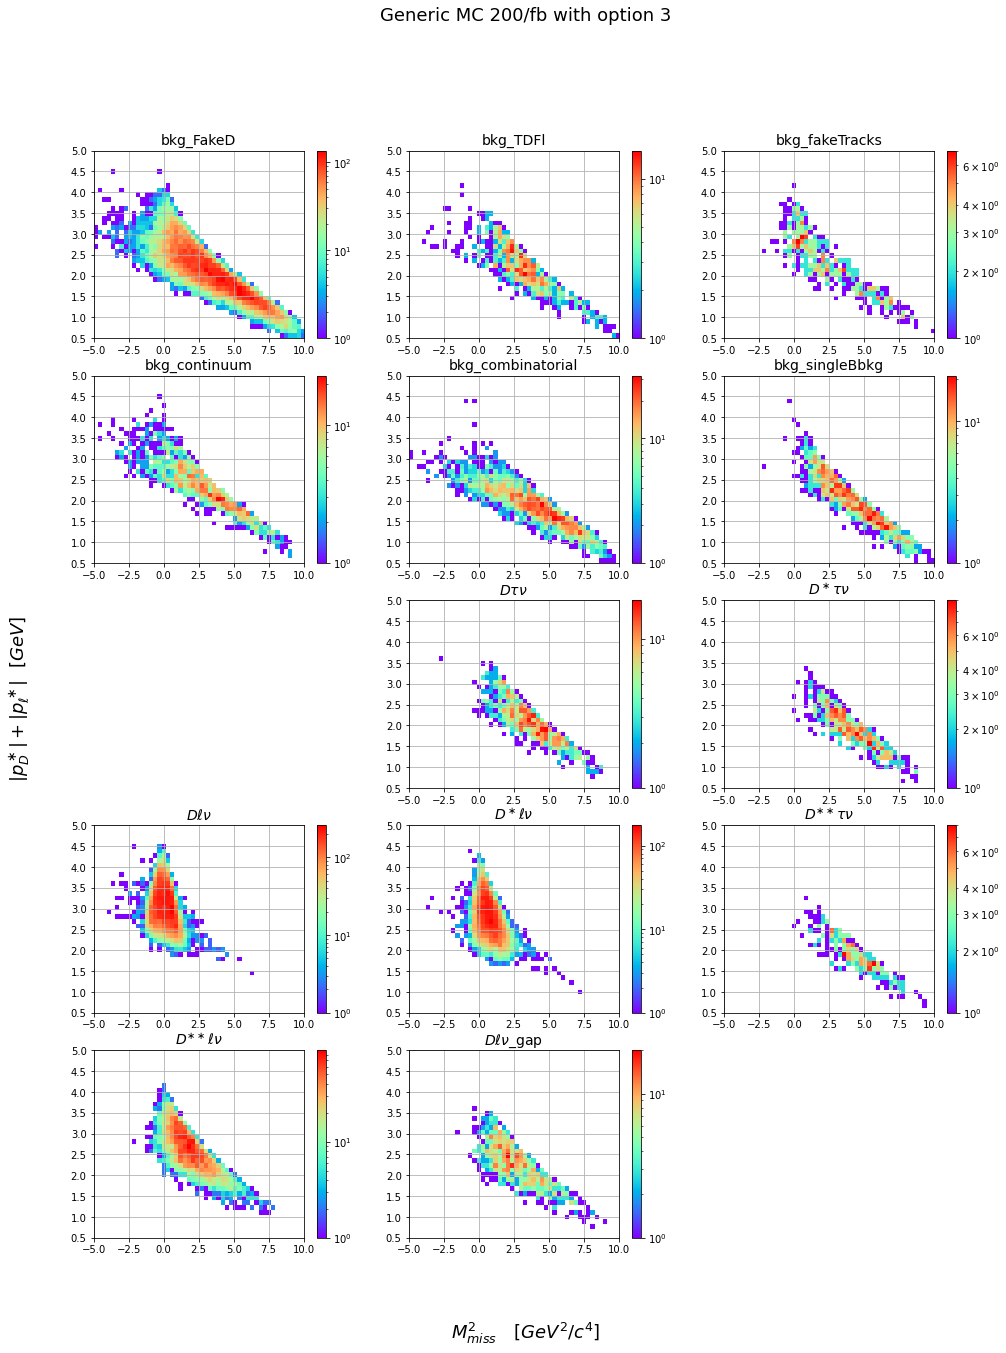

In [24]:
mpl.plot_all_2Dhist(bins=[MM2_bins,p_D_l_bins],variables=['B0_CMS3_weMissM2','p_D_l'],mask=None)
plt.suptitle('Generic MC 200/fb with option 3',size=18);

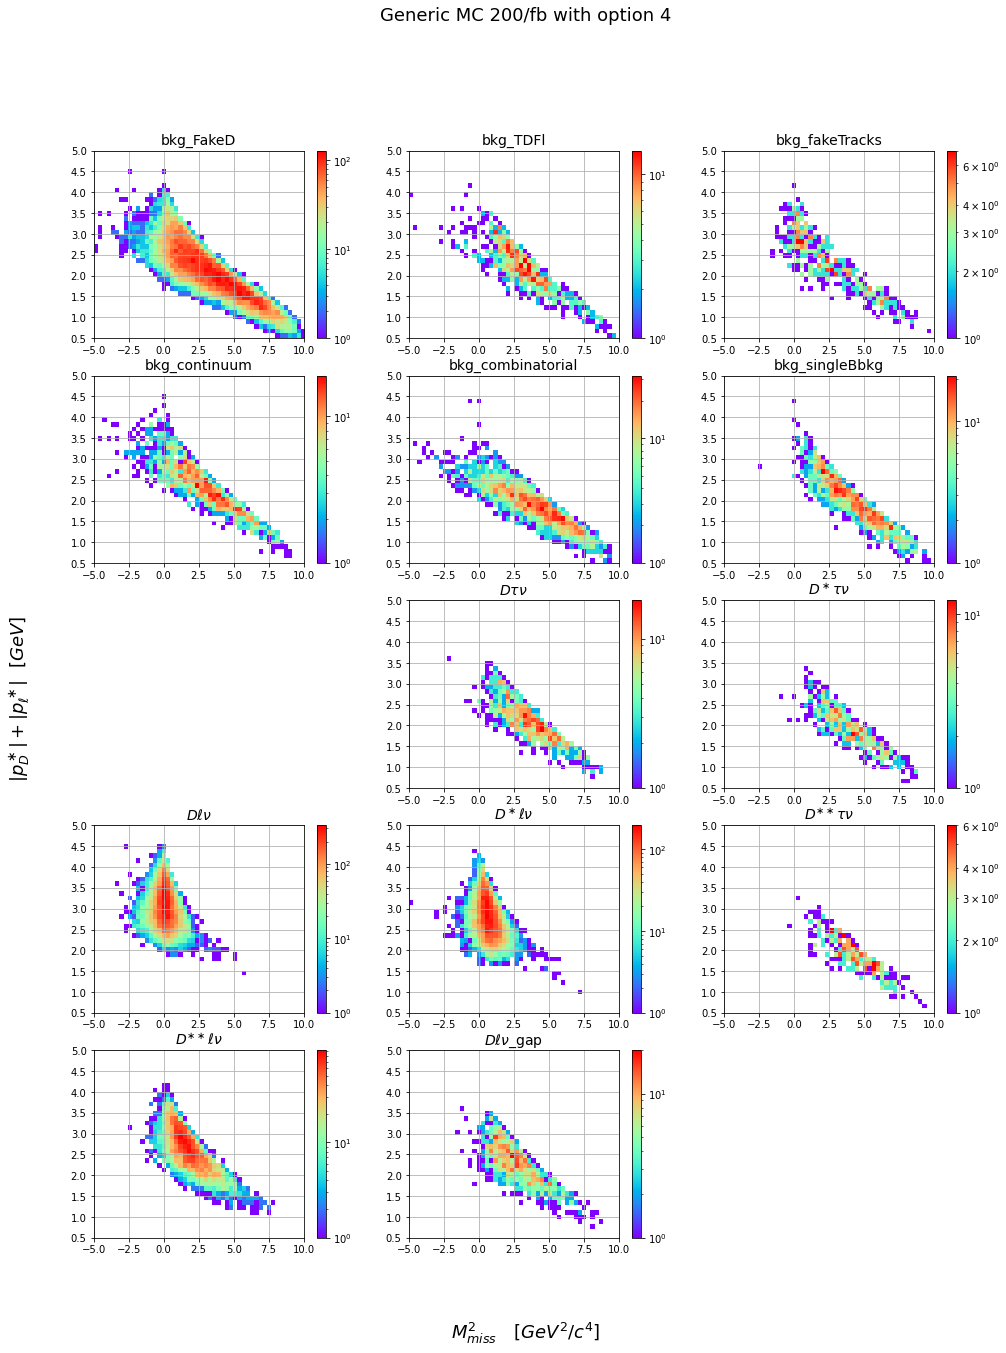

In [25]:
mpl.plot_all_2Dhist(bins=[MM2_bins,p_D_l_bins],variables=['B0_CMS4_weMissM2','p_D_l'],mask=None)
plt.suptitle('Generic MC 200/fb with option 4',size=18);

In [ ]:
samples[r'bkg_singleBbkg'].query('abs(B0_mcPDG)==511')[['B0_mcErrors',
                            'D_genGMPDG','D_genMotherPDG',
                            'ell_genGMPDG','ell_genMotherPDG',
                            'ell_GMdaughter_0_PDG','ell_GMdaughter_1_PDG',
                            'ell_Mdaughter_0_PDG','ell_Mdaughter_1_PDG']][:10]

In [ ]:
samples[r'bkg_singleBbkg'].query('abs(B0_mcPDG)==521')[['B0_mcErrors',
                            'D_genGMPDG','D_genMotherPDG',
                            'ell_genGMPDG','ell_genMotherPDG',
                            'ell_GMdaughter_0_PDG','ell_GMdaughter_1_PDG',
                            'ell_Mdaughter_0_PDG','ell_Mdaughter_1_PDG']][:10]

In [ ]:
samples[r'bkg_singleBbkg'].query('abs(B0_mcPDG)!=521 and abs(B0_mcPDG)!=511')[['B0_mcPDG','B0_mcErrors',
                            'D_genGMPDG','D_genMotherPDG',
                            'ell_genGMPDG','ell_genMotherPDG',
                            'ell_GMdaughter_0_PDG','ell_GMdaughter_1_PDG',
                            'ell_Mdaughter_0_PDG','ell_Mdaughter_1_PDG']]

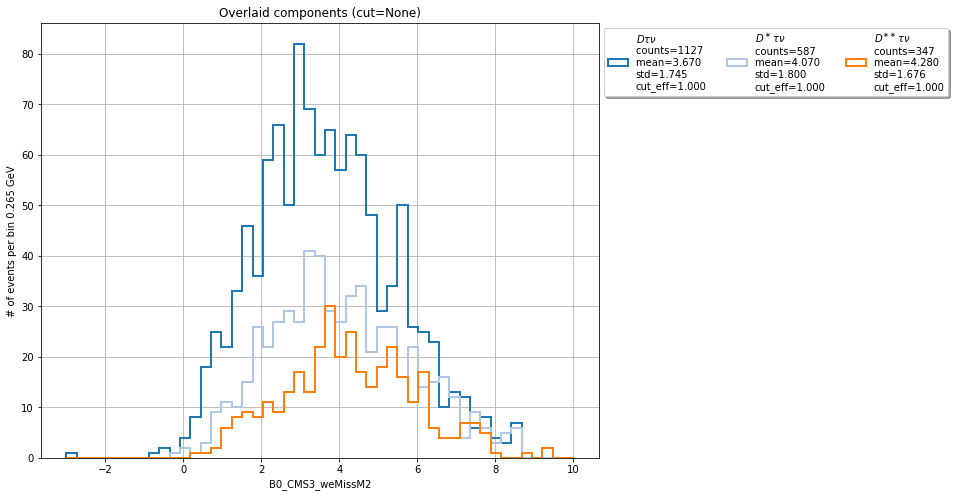

In [31]:
b1 = np.linspace(-3,10,50)
mpl.plot_all_overlaid(variable='B0_CMS3_weMissM2',bins=b1,cut=None,
                      mask=[r'$D\ell\nu$',r'$D^\ast\ell\nu$',r'$D^{\ast\ast}\ell\nu$_res',
                            r'$D^{\ast\ast}\ell\nu$_gap_non','bkg_fakeTracks',
                            'bkg_FDFl', 'bkg_FDTl', 'bkg_TDFl', 'bkg_continuum',
                            'bkg_combinatorial', 'bkg_singleBbkg'],density=False)

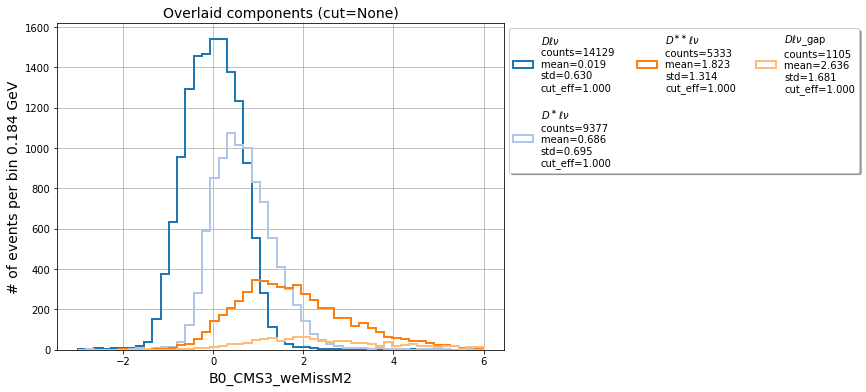

In [30]:
b1 = np.linspace(-3,6,50)
mpl.plot_all_mc_overlaid(variable='B0_CMS3_weMissM2',bins=b1,cut=None,
                      mask=[r'$D\tau\nu$',r'$D^\ast\tau\nu$',r'$D^{\ast\ast}\tau\nu$',
                            'bkg_fakeTracks',
                            'bkg_FakeD','bkg_TDFl', 'bkg_continuum',
                            'bkg_combinatorial', 'bkg_singleBbkg'],density=False)

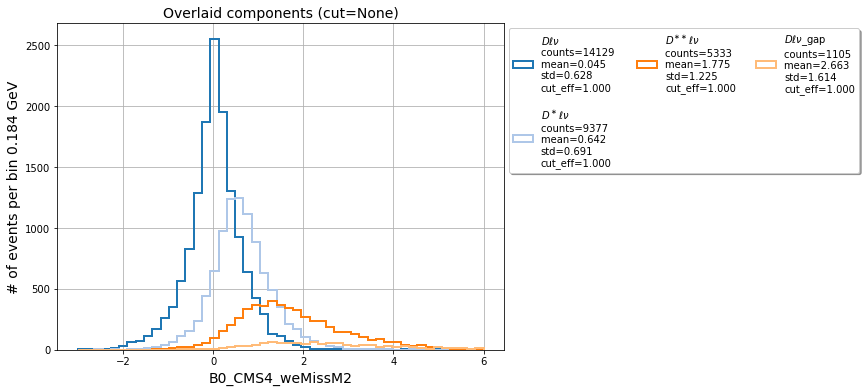

In [29]:
b1 = np.linspace(-3,6,50)
mpl.plot_all_mc_overlaid(variable='B0_CMS4_weMissM2',bins=b1,cut=None,
                      mask=[r'$D\tau\nu$',r'$D^\ast\tau\nu$',r'$D^{\ast\ast}\tau\nu$',
                            'bkg_fakeTracks',
                            'bkg_FakeD','bkg_TDFl', 'bkg_continuum',
                            'bkg_combinatorial', 'bkg_singleBbkg'],density=False)

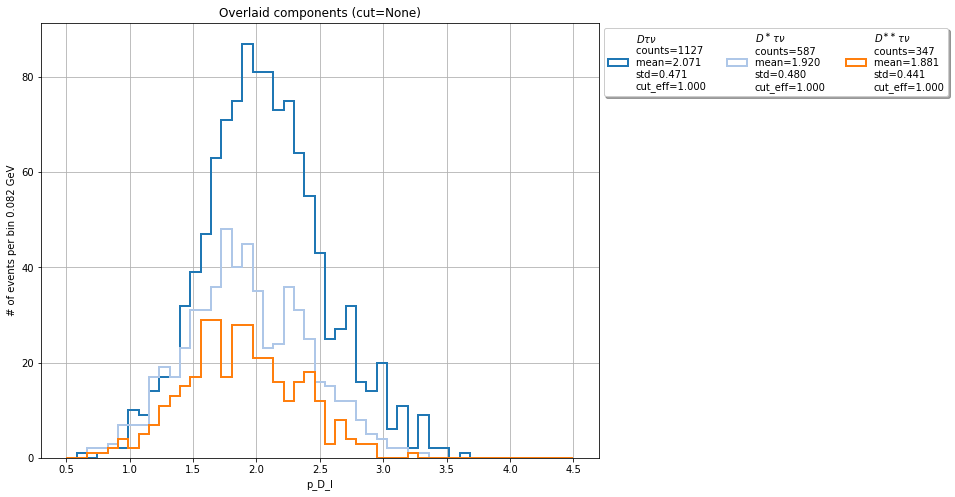

In [35]:
b1 = np.linspace(0.5,4.5,50)
mpl.plot_all_overlaid(variable='p_D_l',bins=b1,cut=None,
                      mask=[r'$D\ell\nu$',r'$D^\ast\ell\nu$',r'$D^{\ast\ast}\ell\nu$_res',
                            r'$D^{\ast\ast}\ell\nu$_gap_non','bkg_fakeTracks',
                            'bkg_FDFl', 'bkg_FDTl', 'bkg_TDFl', 'bkg_continuum',
                            'bkg_combinatorial', 'bkg_singleBbkg'],density=False)

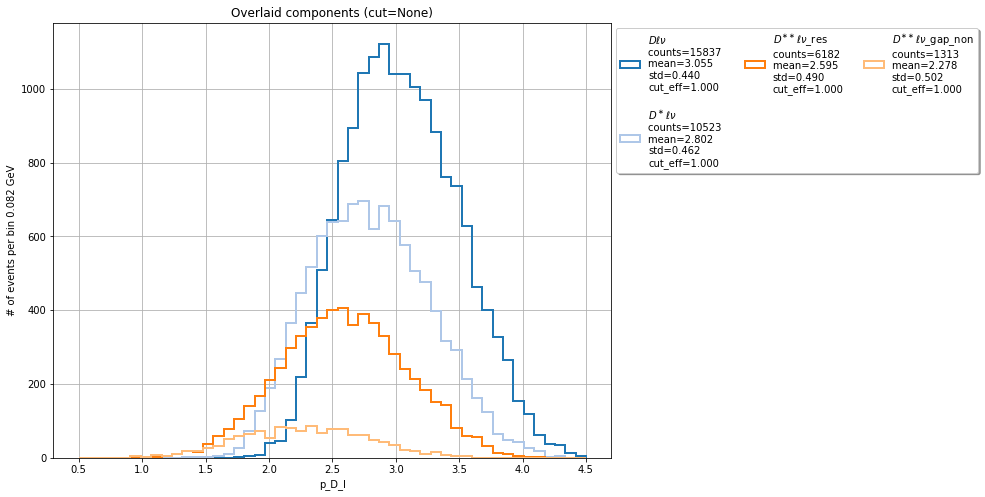

In [36]:
b1 = np.linspace(0.5,4.5,50)
mpl.plot_all_overlaid(variable='p_D_l',bins=b1,cut=None,
                      mask=[r'$D\tau\nu$',r'$D^\ast\tau\nu$',r'$D^{\ast\ast}\tau\nu$',
                            'bkg_fakeTracks',
                            'bkg_FDFl', 'bkg_FDTl', 'bkg_TDFl', 'bkg_continuum',
                            'bkg_combinatorial', 'bkg_singleBbkg'],density=False)

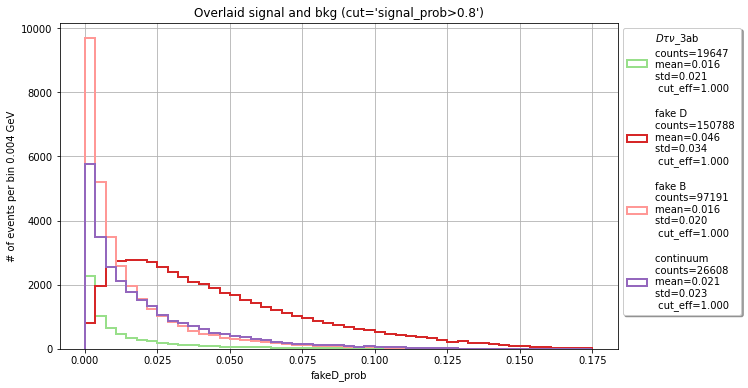

In [9]:
b1 = np.linspace(0,0.175,50)
plot_bkg_overlaid(variable='fakeD_prob',bins=b1,scale=[1/3,1/3,1/3,1],cut='signal_prob>0.8')

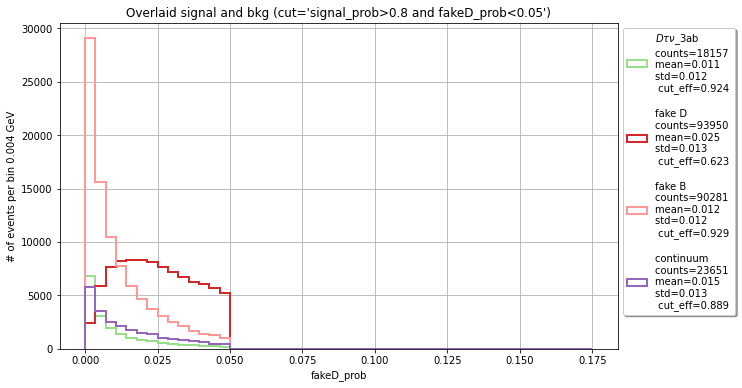

In [45]:
b1 = np.linspace(0,0.175,50)
plot_bkg_overlaid(variable='fakeD_prob',bins=b1,scale=[1,1,1,1],cut='signal_prob>0.8 and fakeD_prob<0.05')

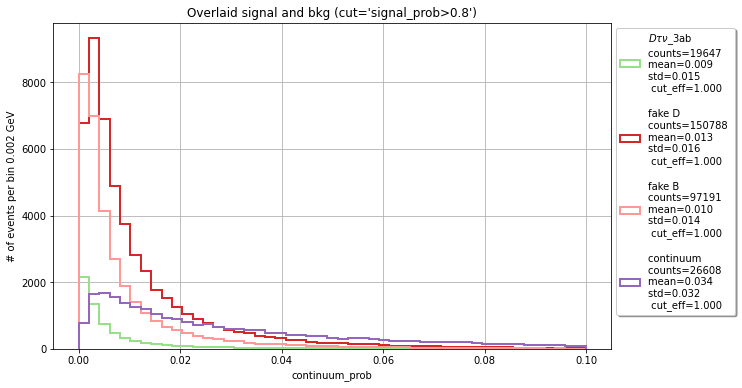

In [12]:
b1 = np.linspace(0,0.1,50)
plot_bkg_overlaid(variable='continuum_prob',bins=b1,scale=[1/3,1/3,1/3,1],cut='signal_prob>0.8')

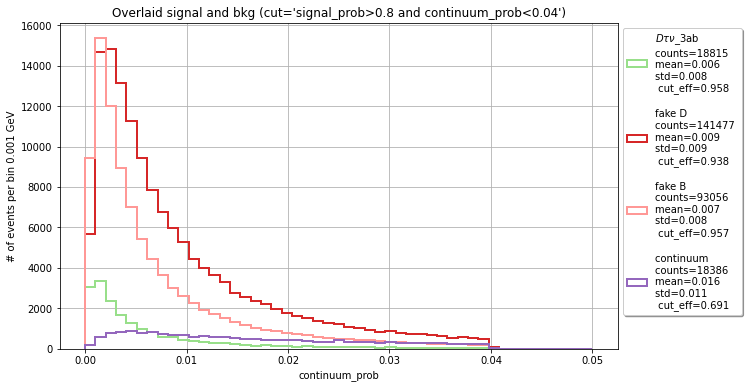

In [31]:
b1 = np.linspace(0,0.05,50)
plot_bkg_overlaid(variable='continuum_prob',bins=b1,scale=[1,1,1,1],cut='signal_prob>0.8 and continuum_prob<0.04')

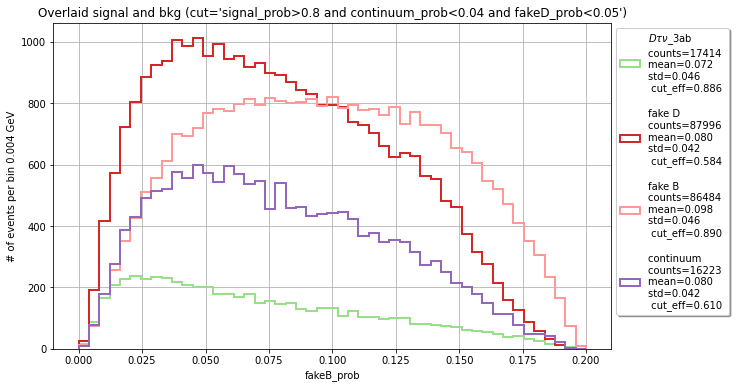

In [16]:
b1 = np.linspace(0,0.2,50)
plot_bkg_overlaid(variable='fakeB_prob',bins=b1,scale=[1/3,1/3,1/3,1],cut='signal_prob>0.8 and continuum_prob<0.04 and fakeD_prob<0.05')

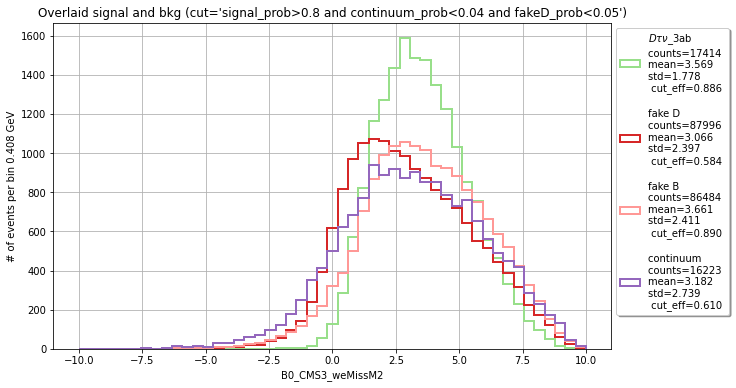

In [30]:
b1 = np.linspace(-10,10,50)
plot_bkg_overlaid(variable='B0_CMS3_weMissM2',bins=b1,scale=[1,16/87,16/86,1],cut='signal_prob>0.8 and continuum_prob<0.04 and fakeD_prob<0.05')

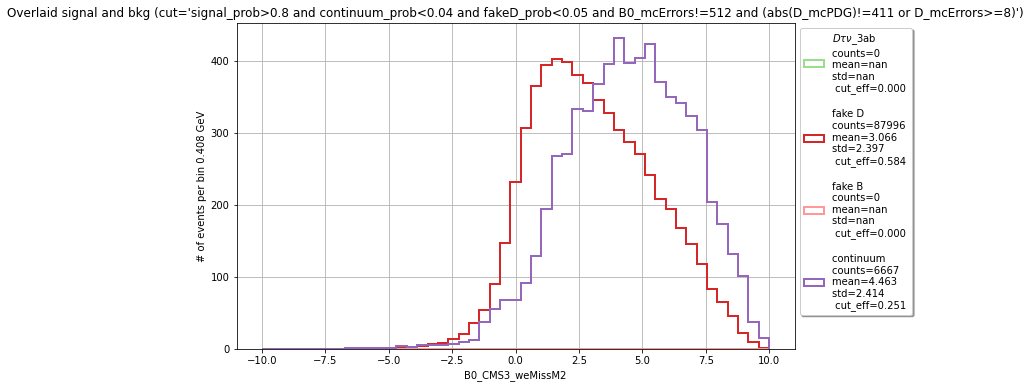

In [25]:
b1 = np.linspace(-10,10,50)
plot_bkg_overlaid(variable='B0_CMS3_weMissM2',bins=b1,scale=[1,6/87,1,1],cut='signal_prob>0.8 and continuum_prob<0.04 and fakeD_prob<0.05 and B0_mcErrors!=512 and (abs(D_mcPDG)!=411 or D_mcErrors>=8)')

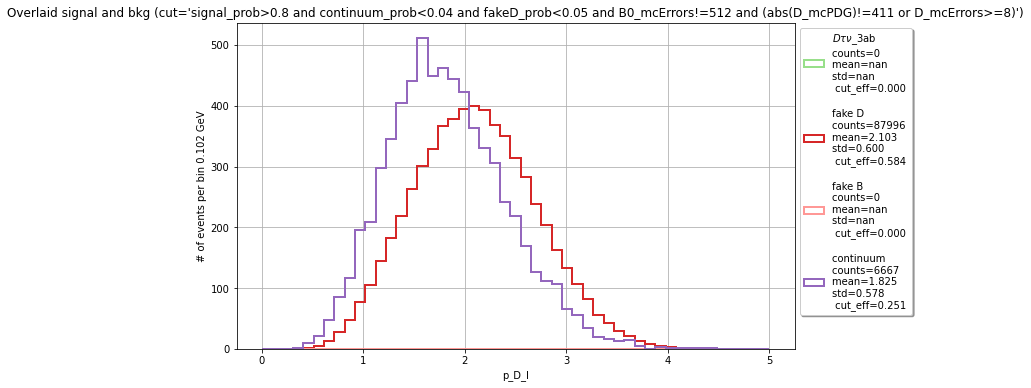

In [36]:
b1 = np.linspace(0,5,50)
plot_bkg_overlaid(variable='p_D_l',bins=b1,scale=[1,6/87,1,1],cut='signal_prob>0.8 and continuum_prob<0.04 and fakeD_prob<0.05 and B0_mcErrors!=512 and (abs(D_mcPDG)!=411 or D_mcErrors>=8)')

In [4]:
local_mc = uproot.concatenate([f'../../Samples/Generic_MC15ri/e_channel/MC15ri_local_200fb_forSingleBbkg/ccbar.root:B0'],
                          library="np")
df_test = pd.DataFrame(local_mc)

In [7]:
df_test = df_test.query('D_daughter_pValue_min>D_daughter_pValue_mean/100')
samples=util.get_dataframe_samples_new(df_test, 'e', template=False)
# mpl=util.mpl(samples)
for name, df in samples.items():
    print(name, len(df))

bkg_FakeD 169562
bkg_TDFl 9045
bkg_fakeTracks 2044
bkg_continuum 65272
bkg_combinatorial 0
bkg_singleBbkg 0
bkg_other_TDTl 0
$D\tau\nu$ 0
$D^\ast\tau\nu$ 0
$D\ell\nu$ 0
$D^\ast\ell\nu$ 0
$D^{\ast\ast}\tau\nu$ 0
$D^{\ast\ast}\ell\nu$ 0
$D\ell\nu$_gap 0
bkg_other_signal 0


In [8]:
# Check for duplicate entries
util.check_duplicate_entries(samples)

No duplicate pairs found.
